<a href="https://colab.research.google.com/github/MJ-best/-DACON-AI-/blob/main/%5BDACON%5DGenome_Info_clf_AI_20220109.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [DACON] 유전체 정보 품종 분류 AI 경진대회
- https://dacon.io/competitions/official/236035/overview/description
- 개체와 SNP 정보를 이용하여 품종 분류 AI 모델 개발
- 유전체 염기서열에서 획득한 유전체 변이 정보인 Single Nucleotide Polymorphism 정보는 특정 개체 및 특정 품종에 따라 다른 변이 양상을 나타낼 수 있기 때문에 동일개체를 확인하거나, 동일 품종을 구분하는데 활용이 가능합니다. 따라서 이번 경진대회에서는 개체 정보와 SNP 정보를 이용하여 A, B, C 품종을 분류하는 최고의 품종구분 정확도를 획득하는 것이 목표입니다.

- 농축수산 현장에서는 유전체 변이정보를 이용해서 품종을 구분하는 연구를 통해 품종의 다양성 혹은 품종 부정유통을 방지하기 위해 많이 활용하게 됩니다.

- SNP란 DNA 내 A, T, G, C와 같은 염기서열의 차이로서 개체 간 염기서열의 차이 정도를 파악하여 분자적인 수준에서의 명확한 품종 조성 확인을 가능케 한다

- 많은 SNP 정보를 통해 분류하는 것보다, 보다 **더 적은 SNP 정보로 높은 분류 성능**을 내는 것이 중요합니다.

- 따라서 이번 경진대회에서는 개체 정보와 사전에 구성된 **15개의 SNP 정보를 바탕으로 품종 분류 모델을 개발**해야 합니다.



In [67]:
import datetime
from pytz import timezone

print("last update : ",datetime.datetime.now(timezone('Asia/Seoul')))

last update :  2023-01-09 23:07:05.768470+09:00


In [68]:
import io
import os
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

from sklearn import preprocessing

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate

import tensorflow as tf

## 데이터준비

In [69]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [70]:
path = '/content/drive/MyDrive/Colab Notebooks/[DACON]유전체정보_품좀_분류_AI_경진대회/data'
os.chdir(path)
df = pd.read_csv("train.csv", encoding='utf-8-sig', error_bad_lines=False)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [71]:
df

,id,father,mother,gender,trait,SNP_01,SNP_02,SNP_03,SNP_04,SNP_05,...,SNP_07,SNP_08,SNP_09,SNP_10,SNP_11,SNP_12,SNP_13,SNP_14,SNP_15,class
0,TRAIN_000,0,0,0,2,G G,A G,A A,G A,C A,...,A A,G G,A A,G G,A G,A A,A A,A A,A A,B
1,TRAIN_001,0,0,0,2,A G,A G,C A,A A,A A,...,A A,G A,A A,A G,A A,G A,G G,A A,A A,C
2,TRAIN_002,0,0,0,2,G G,G G,A A,G A,C C,...,A A,G A,G A,A G,A A,A A,A A,A A,A A,B
3,TRAIN_003,0,0,0,1,A A,G G,A A,G A,A A,...,G G,A A,G G,A G,G G,G G,G G,A A,G G,A
4,TRAIN_004,0,0,0,2,G G,G G,C C,A A,C C,...,A A,A A,A A,G G,A A,A A,A G,A A,G A,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,TRAIN_257,0,0,0,2,A G,A G,A A,G A,C C,...,A A,G A,A A,G G,A G,G A,A A,A A,A A,B
258,TRAIN_258,0,0,0,2,G G,A A,C A,A A,A A,...,G A,G A,A A,A G,A G,A A,A G,A A,G A,C
259,TRAIN_259,0,0,0,1,A G,G G,A A,G A,A A,...,G G,G A,G A,A A,G G,G G,G G,C A,G G,A
260,TRAIN_260,0,0,0,1,A A,G G,A A,G A,A A,...,G G,A A,G A,A G,A G,G A,G G,C A,G G,A


In [72]:
data = df.drop(['id', 'father', 'mother', 'gender', 'trait','class'], axis = 1)

In [73]:
target = df['class']

In [74]:
info = pd.read_csv("snp_info.csv", encoding='utf-8-sig', error_bad_lines=False)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [75]:
info

,SNP_id,name,chrom,cm,pos
0,SNP_01,BTA-19852-no-rs,2,67.05460,42986890
1,SNP_02,ARS-USMARC-Parent-DQ647190-rs29013632,6,31.15670,13897068
2,SNP_03,ARS-BFGL-NGS-117009,6,68.28920,44649549
3,SNP_04,ARS-BFGL-NGS-60567,6,77.87490,53826064
4,SNP_05,BovineHD0600017032,6,80.50150,61779512
5,SNP_06,BovineHD0600017424,6,80.59540,63048481
6,SNP_07,Hapmap49442-BTA-111073,6,80.78000,64037334
7,SNP_08,BovineHD0600018638,6,82.68560,67510588
8,SNP_09,ARS-BFGL-NGS-37727,6,86.87400,73092782
9,SNP_10,BTB-01558306,7,62.06920,40827112


- name : SNP 명
- chrom : 염색체 정보
- cm : Genetic distance
- pos : 각 마커의 유전체상 위치 정보

- 내가 알기로 Genetic distance가 가까울 수록 비슷한 종이고 멀수록 서로 많이 다른 종자가 된다. (computing genetic distance, we can estimate how long ago the two populations were separated)

- SNP는 DNA의 어느 한 부분을 뜻하는 말이고, 여기에 올 수 있는 DNA code가 일반적으로 2종류여서 예를 들어 SNP-1은 A, G가 올수 있기 때문에 SNP-1자리에 올 수 있는 유전자형은 AA, AG, GG 세가지가 된다.

-http://www.incodom.kr/SNP#h_2c088d3d06d5a44395884bd694e4f8ac

## 데이터 전처리
- class(y_train, y_test)는 다중분류므로 라벨 인코딩과 원핫 인코딩을 적용해준다
- SNP는 만들어지는 경우의 수가 3가지 뿐이므로 각 열을 따로 인코딩 해준다
- 0,1,2로 나눠지는 데이터를 MinMax로 0~1 사이로 만들어준다

In [76]:
class CFG:
    SEED = 42

In [77]:
def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(CFG.SEED) # Seed 고정

In [78]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.2, random_state=CFG.SEED, stratify=target)

- y데이터(라벨링)에는 원핫 인코딩을 적용해준다

In [79]:
#먼저 라벨 인코더
target_label = preprocessing.LabelEncoder()
y_train_scaled_ = target_label.fit_transform(y_train)

In [80]:
#원핫인코더
from keras.utils import np_utils
y_train_scaled = np_utils.to_categorical(y_train_scaled_)

- 각 SNP별로 따로따로 인코딩

In [81]:
snp_1 =  preprocessing.LabelEncoder()
snp_2 =  preprocessing.LabelEncoder()
snp_3 =  preprocessing.LabelEncoder()
snp_4 =  preprocessing.LabelEncoder()
snp_5 =  preprocessing.LabelEncoder()
snp_6 =  preprocessing.LabelEncoder()
snp_7 =  preprocessing.LabelEncoder()
snp_8 =  preprocessing.LabelEncoder()
snp_9 =  preprocessing.LabelEncoder()
snp_10 =  preprocessing.LabelEncoder()
snp_11 =  preprocessing.LabelEncoder()
snp_12 =  preprocessing.LabelEncoder()
snp_13 =  preprocessing.LabelEncoder()
snp_14 =  preprocessing.LabelEncoder()
snp_15 =  preprocessing.LabelEncoder()

In [82]:
snp_1.fit(data['SNP_01'])
snp_2.fit(data['SNP_02'])
snp_3.fit(data['SNP_03'])
snp_4.fit(data['SNP_04'])
snp_5.fit(data['SNP_05'])
snp_6.fit(data['SNP_06'])
snp_7.fit(data['SNP_07'])
snp_8.fit(data['SNP_08'])
snp_9.fit(data['SNP_09'])
snp_10.fit(data['SNP_10'])
snp_11.fit(data['SNP_11'])
snp_12.fit(data['SNP_12'])
snp_13.fit(data['SNP_13'])
snp_14.fit(data['SNP_14'])
snp_15.fit(data['SNP_15'])

LabelEncoder()

In [83]:
X_train['SNP_01'] = snp_1.transform(X_train['SNP_01'])
X_train['SNP_02'] = snp_2.transform(X_train['SNP_02'])
X_train['SNP_03'] = snp_3.transform(X_train['SNP_03'])
X_train['SNP_04'] = snp_4.transform(X_train['SNP_04'])
X_train['SNP_05'] = snp_5.transform(X_train['SNP_05'])
X_train['SNP_06'] = snp_6.transform(X_train['SNP_06'])
X_train['SNP_07'] = snp_7.transform(X_train['SNP_07'])
X_train['SNP_08'] = snp_8.transform(X_train['SNP_08'])
X_train['SNP_09'] = snp_9.transform(X_train['SNP_09'])
X_train['SNP_10'] = snp_10.transform(X_train['SNP_10'])
X_train['SNP_11'] = snp_11.transform(X_train['SNP_11'])
X_train['SNP_12'] = snp_12.transform(X_train['SNP_12'])
X_train['SNP_13'] = snp_13.transform(X_train['SNP_13'])
X_train['SNP_14'] = snp_14.transform(X_train['SNP_14'])
X_train['SNP_15'] = snp_15.transform(X_train['SNP_15'])

In [84]:
X_train.head()

,SNP_01,SNP_02,SNP_03,SNP_04,SNP_05,SNP_06,SNP_07,SNP_08,SNP_09,SNP_10,SNP_11,SNP_12,SNP_13,SNP_14,SNP_15
123,1,1,0,2,0,2,2,0,2,0,2,1,2,1,1
189,2,0,1,0,0,1,0,1,0,1,0,0,1,0,0
49,0,2,0,1,0,2,2,0,1,0,2,1,2,1,2
198,2,1,1,0,2,0,0,2,1,2,2,0,1,0,1
29,1,2,0,1,0,2,2,0,1,0,2,2,2,0,2


In [85]:
X_test['SNP_01'] = snp_1.transform(X_test['SNP_01'])
X_test['SNP_02'] = snp_2.transform(X_test['SNP_02'])
X_test['SNP_03'] = snp_3.transform(X_test['SNP_03'])
X_test['SNP_04'] = snp_4.transform(X_test['SNP_04'])
X_test['SNP_05'] = snp_5.transform(X_test['SNP_05'])
X_test['SNP_06'] = snp_6.transform(X_test['SNP_06'])
X_test['SNP_07'] = snp_7.transform(X_test['SNP_07'])
X_test['SNP_08'] = snp_8.transform(X_test['SNP_08'])
X_test['SNP_09'] = snp_9.transform(X_test['SNP_09'])
X_test['SNP_10'] = snp_10.transform(X_test['SNP_10'])
X_test['SNP_11'] = snp_11.transform(X_test['SNP_11'])
X_test['SNP_12'] = snp_12.transform(X_test['SNP_12'])
X_test['SNP_13'] = snp_13.transform(X_test['SNP_13'])
X_test['SNP_14'] = snp_14.transform(X_test['SNP_14'])
X_test['SNP_15'] = snp_15.transform(X_test['SNP_15'])

In [86]:
X_test.head(5)

,SNP_01,SNP_02,SNP_03,SNP_04,SNP_05,SNP_06,SNP_07,SNP_08,SNP_09,SNP_10,SNP_11,SNP_12,SNP_13,SNP_14,SNP_15
15,0,2,0,2,0,2,2,0,2,1,1,1,2,2,2
139,2,2,1,1,2,0,0,2,0,2,0,0,0,0,1
204,0,2,0,1,0,2,2,0,1,1,2,2,2,0,2
114,2,2,1,0,1,1,0,2,0,2,1,0,1,0,0
16,0,2,0,2,0,2,2,0,1,2,1,2,2,1,2


In [87]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled_ = scaler.transform(X_train)
X_test_scaled_ = scaler.transform(X_test)

In [88]:
X_train_scaled = pd.DataFrame(X_train_scaled_, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled_, columns=X_test.columns, index=X_test.index)

In [89]:
X_train_scaled.head(5)

,SNP_01,SNP_02,SNP_03,SNP_04,SNP_05,SNP_06,SNP_07,SNP_08,SNP_09,SNP_10,SNP_11,SNP_12,SNP_13,SNP_14,SNP_15
123,0.5,0.5,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.5,1.0,0.5,0.5
189,1.0,0.0,0.5,0.0,0.0,0.5,0.0,0.5,0.0,0.5,0.0,0.0,0.5,0.0,0.0
49,0.0,1.0,0.0,0.5,0.0,1.0,1.0,0.0,0.5,0.0,1.0,0.5,1.0,0.5,1.0
198,1.0,0.5,0.5,0.0,1.0,0.0,0.0,1.0,0.5,1.0,1.0,0.0,0.5,0.0,0.5
29,0.5,1.0,0.0,0.5,0.0,1.0,1.0,0.0,0.5,0.0,1.0,1.0,1.0,0.0,1.0


## 평가지표
- F1 macro를 사용해 평가한다

In [90]:
#머신러닝 평가지표
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)*100
    precision = precision_score(y_test, pred, average='macro')*100
    recall = recall_score(y_test, pred, average='macro')*100
    f1_macro = f1_score(y_test, pred,  average='macro')
    
    print('오차행렬')
    print(confusion)
    print('정확도 :',"%.1f"%accuracy+'%')
    print('정밀도 :',"%.1f"%precision+'%')
    print('재현율 :', "%.1f"%recall+'%')
    print('Macro F1 score :', f1_macro)

In [91]:
#딥러닝 평가지표(케라스)
from keras import backend as K
def recall(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Negative) = 실제 값이 1(Positive) 전체
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    # return a single tensor value
    return recall


def precision(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Positive) = 예측 값이 1(Positive) 전체
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    # return a single tensor value
    return precision


def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    
    # return a single tensor value
    return _f1score

## 머신러닝 알고리즘

In [92]:
#Scikit-Optimize를 이용해 파라미터 자동 튜닝
!pip install -q scikit-optimize 

### 랜덤포레스트 모델을 사용해서 학습
- 분류기 : ran_clf
- F1 score : 0.916

In [93]:
ran_clf = RandomForestClassifier(random_state=CFG.SEED)
ran_clf.fit(X_train_scaled, y_train_scaled)
ran_pred_scaled = ran_clf.predict(X_test_scaled)

In [94]:
#원 핫 인코딩 -> 라벨 -> 
index = np.argmax(ran_pred_scaled, axis=1)
ran_pred = pd.DataFrame()
ran_pred = target_label.inverse_transform(index)

In [95]:
get_clf_eval(y_test, ran_pred)

오차행렬
[[14  0  0]
 [ 0 23  0]
 [ 2  2 12]]
정확도 : 92.5%
정밀도 : 93.2%
재현율 : 91.7%
Macro F1 score : 0.9162698412698412


## GBM 모델을 사용해서 학습
- 분류기 : gb_clf
- F1 score : 0.9638
- 파라미터 튜닝후 F1 score : 0.9638

In [96]:
from sklearn.ensemble import GradientBoostingClassifier

gb_clf = GradientBoostingClassifier(random_state=CFG.SEED)
gb_clf.fit(X_train_scaled, y_train_scaled_)
gb_pred_scaled_ = gb_clf.predict(X_test_scaled)

In [97]:
# 라벨인코더 -> 타겟
gb_pred = target_label.inverse_transform(gb_pred_scaled_)

In [98]:
get_clf_eval(y_test, gb_pred)

오차행렬
[[14  0  0]
 [ 0 23  0]
 [ 0  2 14]]
정확도 : 96.2%
정밀도 : 97.3%
재현율 : 95.8%
Macro F1 score : 0.9638888888888889


In [99]:
gb_clf.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 42,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [100]:
from skopt import BayesSearchCV

gb_clf = GradientBoostingClassifier(random_state=CFG.SEED)

gb_opt = BayesSearchCV(
    gb_clf,
    {
    'n_estimators' : (100, 1000),
    'min_samples_split': (2,4),
    'learning_rate': (0.01, 0.1)
    },
    n_iter = 10,
    cv = 5
)

gb_opt.fit(X_train_scaled, y_train_scaled_)

gb_opt_pred_scaled_ = gb_opt.predict(X_test_scaled)

In [101]:
gb_opt_pred = target_label.inverse_transform(gb_opt_pred_scaled_)

In [102]:
get_clf_eval(y_test, gb_opt_pred)

오차행렬
[[14  0  0]
 [ 0 23  0]
 [ 0  2 14]]
정확도 : 96.2%
정밀도 : 97.3%
재현율 : 95.8%
Macro F1 score : 0.9638888888888889


In [103]:
gb_opt.best_params_

OrderedDict([('learning_rate', 0.050034926107103674),
             ('min_samples_split', 4),
             ('n_estimators', 194)])

## Linear SVC 모델을 이용해 학습
- 분류기 : svm
- F1 score : 0.927
- 파라미터 튜닝후 : 0.982

In [104]:
from sklearn.svm import LinearSVC

svm = LinearSVC(random_state=CFG.SEED)
svm.fit(X_train_scaled, y_train_scaled_)
svm_pred_scaled_ = svm.predict(X_test_scaled)

In [105]:
# 라벨인코더 -> 타겟
svm_pred = target_label.inverse_transform(svm_pred_scaled_)

In [106]:
get_clf_eval(y_test, svm_pred)

오차행렬
[[14  0  0]
 [ 0 22  1]
 [ 0  3 13]]
정확도 : 92.5%
정밀도 : 93.6%
재현율 : 92.3%
Macro F1 score : 0.9277777777777777


In [107]:
#svm의 하이퍼파라미터를 조회해보자
svm.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': True,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'loss': 'squared_hinge',
 'max_iter': 1000,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': 42,
 'tol': 0.0001,
 'verbose': 0}

In [ ]:
from skopt import BayesSearchCV

svm = LinearSVC(random_state=CFG.SEED)

svm_opt = BayesSearchCV(
    svm,
    {'C' : (10.0, 100.0, 'log-uniform'),
     'max_iter': (1000, 10000),
    },
    n_iter = 10,
    cv = 5
)

svm_opt.fit(X_train_scaled, y_train_scaled_)

svm_opt_pred_scaled_ = svm_opt.predict(X_test_scaled)

In [109]:
svm_opt_pred = target_label.inverse_transform(svm_opt_pred_scaled_)

In [110]:
get_clf_eval(y_test, svm_opt_pred)

오차행렬
[[14  0  0]
 [ 0 23  0]
 [ 0  1 15]]
정확도 : 98.1%
정밀도 : 98.6%
재현율 : 97.9%
Macro F1 score : 0.9821551132463967


In [111]:
svm_opt.best_params_

OrderedDict([('C', 37.540218527310444), ('max_iter', 4432)])

### 분류에 도움이 되는 주요한 데이터에 관해서만 학습
- 2022년 12월 30일
- 시도해봤는데 머신러닝에서도 딥러닝에서도 좋은 성능을 얻지 못했다
- Xtra-tree : Macro F1 score 0.17316017316017315
- Deeplearning : Macro F1 score 0.07165532879818594

In [113]:
#변수별 중요도를 이용해 특성행렬 선택후 학습
from sklearn.feature_selection import SelectFromModel

selector = SelectFromModel(ran_clf, threshold = 'median')

In [125]:
X_train_feature_important = selector.fit_transform(X_train_scaled, y_train_scaled)
X_test_feature_important = selector.fit_transform(X_test_scaled, y_test)

In [126]:
# 엑스트라 트리로 주요변수에 대해서만 학습
from sklearn.ensemble import ExtraTreesClassifier
clf_important = ExtraTreesClassifier(n_estimators=100, random_state=CFG.SEED)
clf_important.fit(X_train_feature_important, y_train)

ExtraTreesClassifier(random_state=42)

In [127]:
pred1 = clf_important.predict(X_test_feature_important)

In [128]:
pred1

array(['C', 'A', 'B', 'A', 'C', 'B', 'C', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'B', 'B', 'B', 'A', 'A', 'B', 'A', 'A', 'A', 'C', 'C', 'A',
       'A', 'B', 'A', 'A', 'A', 'A', 'A', 'B', 'C', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'B', 'C', 'A', 'C', 'A', 'A', 'B', 'A', 'C',
       'A'], dtype=object)

In [122]:
#원핫인코딩을 먼저 디코딩 한 다음 라벨인코더로 되돌리기
index1 = np.argmax(pred1)

In [123]:
#라벨디코더를 이용해 되돌리기
preds1 = pd.DataFrame()
preds1 = target_label.inverse_transform(index1)

ValueError: ignored

In [120]:
get_clf_eval(y_test, preds1)

ValueError: ignored

In [ ]:
model = tf.keras.Sequential([
                             tf.keras.layers.Dense(units=8, activation='relu', input_dim=X_train_feature_important.shape[1]),
                             tf.keras.layers.Dense(units=100, activation='relu'),
                             tf.keras.layers.Dense(units=100, activation='relu'),
                             tf.keras.layers.Dense(units=3, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.07),
              loss='categorical_crossentropy', metrics=['accuracy', precision, recall, f1score])

model.summary()

In [ ]:
history = model.fit(X_train_feature_important, y_train, epochs=1000, batch_size=50, validation_split=0.25, callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')])

In [ ]:
y_hat = model.predict(X_test_feature_important)

In [ ]:
index = np.argmax(y_hat, axis=1)

In [ ]:
preds = pd.DataFrame()
preds = target_label.inverse_transform(index)

In [ ]:
get_clf_eval(y_test, preds)

## 딥러닝 다중분류모델을 이용해서 풀어보자

In [129]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD

### SGD와 Dropout를 이용한 다중분류모델
- F1 score : 0.982


In [130]:
dna_model = Sequential()
dna_model.add(Dense(64, activation='relu', input_dim=X_train_scaled.shape[1]))
dna_model.add(Dropout(0.5))
dna_model.add(Dense(192, activation='relu'))
dna_model.add(Dropout(0.5))
dna_model.add(Dense(192, activation='relu'))
dna_model.add(Dropout(0.5))
dna_model.add(Dense(192, activation='relu'))
dna_model.add(Dropout(0.5))
dna_model.add(Dense(64, activation='relu'))
dna_model.add(Dropout(0.5))
dna_model.add(Dense(3, activation='softmax'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
dna_model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy',precision, recall, f1score])

dna_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 64)                1024      
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 dense_17 (Dense)            (None, 192)               12480     
                                                                 
 dropout_11 (Dropout)        (None, 192)               0         
                                                                 
 dense_18 (Dense)            (None, 192)               37056     
                                                                 
 dropout_12 (Dropout)        (None, 192)               0         
                                                                 
 dense_19 (Dense)            (None, 192)              

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
hist = dna_model.fit(X_train_scaled, y_train_scaled, epochs=1000, batch_size=50, validation_split=0.25, callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')])

In [132]:
y_hat = dna_model.predict(X_test_scaled)

2/2 [==============================] - 0s 7ms/step


In [133]:
index = np.argmax(y_hat, axis=1)
dna_pred = pd.DataFrame()
dna_pred = target_label.inverse_transform(index)

In [134]:
get_clf_eval(y_test, dna_pred)

오차행렬
[[14  0  0]
 [ 0 23  0]
 [ 0  2 14]]
정확도 : 96.2%
정밀도 : 97.3%
재현율 : 95.8%
Macro F1 score : 0.9638888888888889


- 시각화

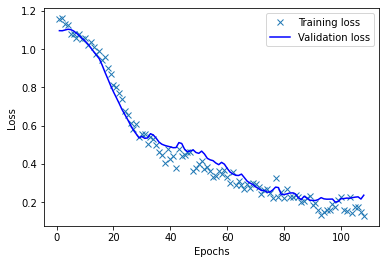

In [141]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "x", label = "Training loss")
plt.plot(epochs, val_loss, "b", label = "Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

### Adam을 이용한 다중분류모델
- F1 score : 0.94

In [142]:
adam_model = Sequential()
adam_model.add(Dense(64, activation='relu', input_dim=X_train_scaled.shape[1]))
adam_model.add(Dense(125, activation='relu'))
adam_model.add(Dense(100, activation='relu'))
adam_model.add(Dense(units=3, activation='softmax'))

adam_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss='categorical_crossentropy', metrics=['accuracy', precision, recall, f1score])

adam_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 64)                1024      
                                                                 
 dense_23 (Dense)            (None, 125)               8125      
                                                                 
 dense_24 (Dense)            (None, 100)               12600     
                                                                 
 dense_25 (Dense)            (None, 3)                 303       
                                                                 
Total params: 22,052
Trainable params: 22,052
Non-trainable params: 0
_________________________________________________________________


In [143]:
hist = adam_model.fit(X_train_scaled, y_train_scaled, epochs=1000, batch_size=50, validation_split=0.25, callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')])

Epoch 1/1000
4/4 [==============================] - 1s 116ms/step - loss: 0.8538 - accuracy: 0.6026 - precision: 0.6732 - recall: 0.5100 - f1score: 0.5505 - val_loss: 0.6601 - val_accuracy: 0.5849 - val_precision: 0.7917 - val_recall: 0.7800 - val_f1score: 0.7857
Epoch 2/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3761 - accuracy: 0.7949 - precision: 0.8021 - recall: 0.7983 - f1score: 0.8002 - val_loss: 0.4976 - val_accuracy: 0.6792 - val_precision: 0.8333 - val_recall: 0.8200 - val_f1score: 0.8265
Epoch 3/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2773 - accuracy: 0.8526 - precision: 0.8483 - recall: 0.8483 - f1score: 0.8483 - val_loss: 0.4810 - val_accuracy: 0.7736 - val_precision: 0.7233 - val_recall: 0.7233 - val_f1score: 0.7233
Epoch 4/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2777 - accuracy: 0.8782 - precision: 0.9050 - recall: 0.9050 - f1score: 0.9050 - val_loss: 0.4774 - val_accuracy: 0.7170 - val_precisio

In [144]:
y_hat = adam_model.predict(X_test_scaled)

2/2 [==============================] - 0s 6ms/step


In [145]:
index = np.argmax(y_hat, axis=1)

In [146]:
preds = pd.DataFrame()
preds = target_label.inverse_transform(index)

In [147]:
get_clf_eval(y_test, preds)

오차행렬
[[14  0  0]
 [ 0 22  1]
 [ 0  2 14]]
정확도 : 94.3%
정밀도 : 95.0%
재현율 : 94.4%
Macro F1 score : 0.9464653397391901


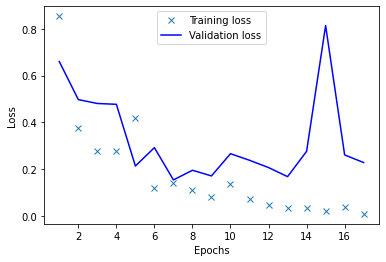

In [148]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "x", label = "Training loss")
plt.plot(epochs, val_loss, "b", label = "Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

## 드롭아웃을 적용시켜 아주 깊은 딥러닝 모델을 만들어보자
- 드롭아웃층을 적용했다
- 깊은 모델일 때 relu보다 좀더 미분값 소실이 적다는 swish함수를 사용했다

In [ ]:
model1 = tf.keras.Sequential([
                             tf.keras.layers.Dense(units=1050, activation='swish', input_dim=X_train_scaled.shape[1]),
                             tf.keras.layers.Dense(units=100, activation='swish'),
                             tf.keras.layers.Dropout(0.2), 
                             tf.keras.layers.Dense(units=100, activation='swish'),
                             tf.keras.layers.Dropout(0.2), 
                             tf.keras.layers.Dense(units=100, activation='swish'),
                             tf.keras.layers.Dropout(0.2), 
                             tf.keras.layers.Dense(units=100, activation='swish'),
                             tf.keras.layers.Dropout(0.2), 
                             tf.keras.layers.Dense(units=100, activation='swish'),
                             tf.keras.layers.Dropout(0.2), 
                             tf.keras.layers.Dense(units=100, activation='swish'),
                             tf.keras.layers.Dense(units=3, activation='softmax')
])

model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.07),
              loss='categorical_crossentropy', metrics=['accuracy', precision, recall, f1score])

model1.summary()

In [ ]:
history = model1.fit(X_train_scaled, y_train, epochs=1000, batch_size=32, validation_split=0.25, callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')])

In [ ]:
y_hat1 = model1.predict(X_test_scaled)

In [ ]:
index1 = np.argmax(y_hat1, axis=1)

In [ ]:
preds1 = pd.DataFrame()
preds1 = target_label.inverse_transform(index1)

In [ ]:
get_clf_eval(y_test, preds1)

- 어째 결과가 더 안좋게 나오네...
